# Applying CFL to the El Niño Dataset

This notebook demonstrates how to run Causal Feature Learning (CFL) on the El
Niño dataset. This dataset is comprised of wind speed (WS) and sea surface
temperature (SST) measurements in a region of the pacific ocean. By looking at
the conditional relationship between these two variables, CFL can aggregate
these low-level measurements into coarser macrovariables that represent ocean
climate phenomena such as El Niño and La Niña SST patterns.



In [27]:
# imports
import os                                               # manage paths
import joblib                                           # load data
from sklearn.preprocessing import StandardScaler        # standardize data
from cfl.experiment import Experiment                   # run CFL
import numpy as np
import matplotlib as mpl                                # visualize data
import matplotlib.pyplot as plt                         # visualize data
from mpl_toolkits.axes_grid1 import make_axes_locatable # visualize data
from matplotlib.cm import ScalarMappable                # visualize data
import matplotlib.patches as patches                    # visualize data

# constants
WS_CMAP = 'BrBG_r'
SST_CMAP = 'coolwarm'
IMSHAPE = (55, 9)
FIG_PATH = 'el_nino_figures'
mpl.rcParams['xtick.labelsize'] = 10 
mpl.rcParams['ytick.labelsize'] = 10 

### Load Data
First, we load in the data as variables X and Y, and standardize both X and Y to improve
neural network training efficiency. An example sample (WS and SST measurements at the same time point) is plotted below.

In [28]:
# load data
data_path = '../../../data/el_nino/elnino_data.pkl' # set this to your local path to your data
Xraw, Yraw, coords = joblib.load(data_path)
print('Xraw shape: {}'.format(Xraw.shape))
print('Yraw shape: {}'.format(Yraw.shape))

Xraw shape: (13140, 495)
Yraw shape: (13140, 495)


In [37]:
# pacific map plotting helper function
def plot_contour_map(data, ax, imshape, title, cmap, cmap_label, vmin=None, 
                     vmax=None, xlabel='Longitude (°)', ylabel='Latitude (°)',
                     rect=False, add_colorbar=True):
    '''
    A helper function that plots a wind speed or sea surface temperature map on
    a provided axis.  
    Arguments:
        data (np.ndarray) : a vectorized WS or SST map
        ax (matplotlib.axes) : a matplotlib.pyplot subplot
        imshape (tuple) : dimensions to reshape vectorized map to
        title (str) : subplot title
        cmap (str) : matplotlib color map for ax.contourf()
        cmap_label (str) : label for color value
        vmin (np.float) : minimum color value to plot
        vmax (np.float) : maximimum color value to plot
        xlabel (str) : x axis label, defaults to 'Longitude (°)'
        ylabel (str) : y axis label, defaults to 'Latitude (°)'
        rect (bool) : whether to add a rectangle of the standard el niño region
    Returns:
        matplotlib.contour.QuadContourSet : image object
    '''

    # create a rectangle marking el niño region
    if rect:
        rect = patches.Rectangle((190, -5), 50, 10, linewidth=2, 
                                 edgecolor='black', facecolor='none', 
                                 linestyle='--')
        ax.add_patch(rect)
    
    # plot reshaped data
    im = ax.contourf(coords['x'].ravel(), coords['y'].ravel(), 
                     data.reshape(imshape).T, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title,  fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold', rotation=0, 
        labelpad=25, loc='bottom')

    # add colorbar
    if add_colorbar:
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
        cb = fig.colorbar(ScalarMappable(norm=im.norm, cmap=im.cmap), cax=cax, 
                                        orientation='vertical')
        cb.set_label(label=cmap_label, rotation=-90, fontsize=10, 
                    labelpad=15)
    return im

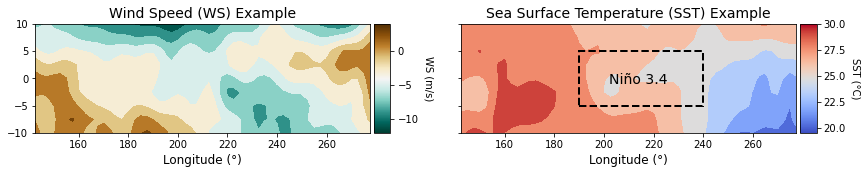

In [38]:
# plot an example WS and SST image pair               
fig,ax = plt.subplots(1, 2, figsize=(14,2), sharex=True, sharey=True)
plot_contour_map(data=Xraw[0], ax=ax[0], imshape=IMSHAPE, 
                 title='Wind Speed (WS) Example', cmap=WS_CMAP, 
                 cmap_label='WS (m/s)', ylabel='', rect=False, add_colorbar=True)
plot_contour_map(data=Yraw[0], ax=ax[1], imshape=IMSHAPE, 
                 title='Sea Surface Temperature (SST) Example', cmap=SST_CMAP, 
                 cmap_label='SST (°C)', ylabel='', rect=True, add_colorbar=True)
ax[1].text(202, -1, "Niño 3.4", fontsize=14)
plt.savefig(os.path.join(FIG_PATH, 'sample_ws_sst'))
plt.show()

In [31]:
# standardize data
X = StandardScaler().fit_transform(Xraw)
Y = StandardScaler().fit_transform(Yraw)

### Run CFL

CFL is composed of two main steps. First, a conditional density estimator (CDE) is used to approximate the probability of Y given X. Second, this conditional relationship is clustered to form a partitioning of X and a partitioning of Y. To run CFL, we first set parameters for each of these steps (this is done below in defining `CDE_params` and `cluster_params`).

We can then define an `Experiment` with these parameters and train it to learn a mapping from microvariables to macrovariables. 

In [6]:
# set all CFL parameters

# generic data parameters
data_info = { 'X_dims' : X.shape, 
              'Y_dims' : Y.shape,
              'Y_type' : 'continuous'} 

# CDE parameters
lr = 1e-4
CDE_params = {  'model'        : 'CondExpMod',
                'model_params' : {
                    'batch_size'  : 128,
                    'optimizer'   : 'adam',
                    'opt_config'  : {'lr': 1e-4},
                    'n_epochs'    : 1000,
                    'verbose'     : 1,
                    'dense_units' : [1024, 1024, data_info['Y_dims'][1]],
                    'activations' : ['linear', 'linear', 'linear'],
                    'dropouts'    : [0.5, 0.5, 0.0],
                    'early_stopping' : True,
                    'weights_path'   : 'el_nino_results/experiment0000/trained_blocks/CDE'
                }
}

# clusterer parameters
cause_cluster_params =  {'model' : 'KMeans',
                         'model_params' : {'n_clusters' : range(2,21)},
                         'verbose' : 0,
                         'tune' : True}

effect_cluster_params = {'model' : 'KMeans',
                         'model_params' : {'n_clusters' : range(2,21)}, 
                         'verbose' : 0,
                         'precompute_distances' : True,
                         'tune' : True}

All results from this run will be saved to el_nino_results/experiment0001
Block: verbose not specified in input, defaulting to 1
CondExpBase: activity_regularizers not specified in input, defaulting to None
CondExpBase: kernel_regularizers not specified in input, defaulting to None
CondExpBase: bias_regularizers not specified in input, defaulting to None
CondExpBase: kernel_initializers not specified in input, defaulting to None
CondExpBase: bias_initializers not specified in input, defaulting to None
CondExpBase: loss not specified in input, defaulting to mean_squared_error
CondExpBase: show_plot not specified in input, defaulting to True
CondExpBase: best not specified in input, defaulting to True
CondExpBase: tb_path not specified in input, defaulting to None
CondExpBase: optuna_callback not specified in input, defaulting to None
CondExpBase: optuna_trial not specified in input, defaulting to None
CondExpBase: checkpoint_name not specified in input, defaulting to tmp_checkpoints
Loa

0it [00:00, ?it/s]

Saving parameters to  el_nino_results/experiment0001/trained_blocks/CondDensityEstimator
CondDensityEstimator training complete.
Beginning CauseClusterer training...
Beginning clusterer tuning


19it [10:19, 32.59s/it]


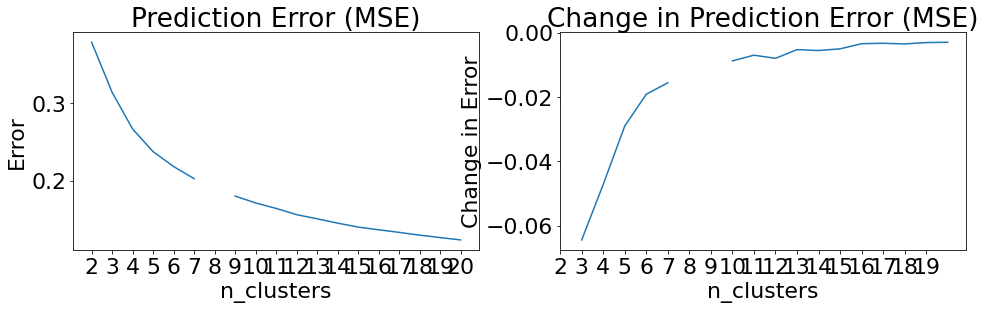

Please choose your final clustering parameters.
Final parameters:  {'n_clusters': 8}
CauseClusterer training complete.
Beginning EffectClusterer training...


100%|██████████| 13140/13140 [00:04<00:00, 3217.72it/s]
0it [00:00, ?it/s]

Beginning clusterer tuning


19it [00:30,  1.59s/it]


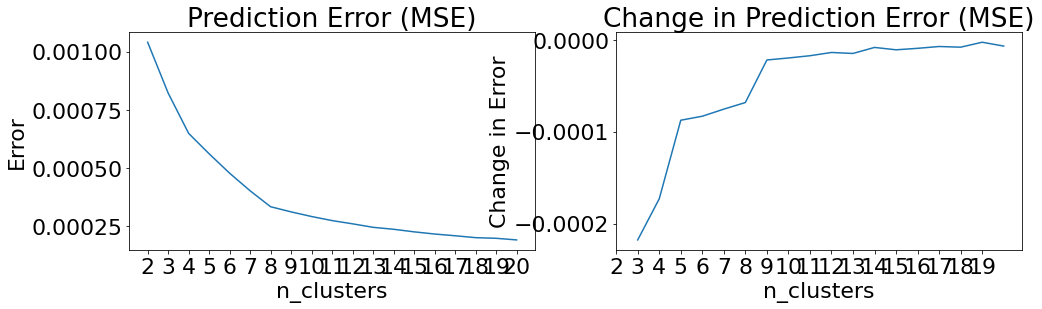

Please choose your final clustering parameters.
Final parameters:  {'n_clusters': 8}
EffectClusterer training complete.
Experiment training complete.


In [7]:
block_names = ['CondDensityEstimator', 'CauseClusterer', 'EffectClusterer']
block_params = [CDE_params, cause_cluster_params, effect_cluster_params]
save_path = 'el_nino_results'

my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info, 
                    block_names=block_names, block_params=block_params, 
                    blocks=None, verbose=1, results_path=save_path)

train_results = my_exp.train()

Now that the CFL pipeline has been trained, we can access the results from training in the `train_results` dictionary. Below, we can see that CFL has constructed a labeling of our wind speed data that identifies the macrovariable class that each sample belongs to. 

In [10]:
xlbls = train_results['CauseClusterer']['x_lbls']
ylbls = train_results['EffectClusterer']['y_lbls']

print('X macrovariable states:')
print(np.unique(xlbls))
print('Y macrovariable states:')
print(np.unique(ylbls))

X macrovariable states:
[0 1 2 3 4 5 6 7]
Y macrovariable states:
[0 1 2 3 4 5 6 7]


### Visualize Results

Lastly, we can visualize the macrovariable states CFL discovered by plotting 
the average difference between microvariable samples in each state and the 
global mean. First, we will define a couple helper functions to handle the
plotting.

In [39]:
def compute_macrostate_means(data, lbls):
    # how many macrostates do we have
    ulbls = np.unique(lbls)
    nulbls = len(ulbls)

    # for each macrostate, compute the mean
    means = np.zeros((nulbls, data.shape[1]))
    for ui,ulbl in enumerate(ulbls):
        means[ui] = np.mean(data[lbls==ulbl], axis=0)
    
    return means

def plot_macrostate_means(data, lbls, cmap_label, c_or_e, series_label):
    # how many macrostates do we have
    ulbls = np.unique(lbls)
    nulbls = len(ulbls)

    # compute means
    means = compute_macrostate_means(data, lbls)
    
    # compute bounds for colormap to be centered at 0
    bound = np.max(np.abs([np.min(means), np.max(means)]))
    vmin,vmax = -bound,bound
    
    # make figure where each subplot is one macrostate average
    fig,ax = plt.subplots(nulbls, 1, figsize=(3,nulbls+1), sharex=True, sharey=True)
    for ui,ulbl in enumerate(ulbls):

        # define subplot labels depending on location in figure
        if ui==nulbls-1:
            xlabel, cmap_label = 'Longitude (°)', cmap_label
        else:
            xlabel, cmap_label = None, None
        
        # make contour plot
        cmap = WS_CMAP if series_label=='WS' else SST_CMAP
        im = plot_contour_map(data=means[ui], ax=ax[ui], imshape=IMSHAPE, 
                              title=None, cmap=cmap, cmap_label=cmap_label,
                              vmin=vmin, vmax=vmax, xlabel=xlabel, ylabel='',
                              add_colorbar=False)

        # overwrite helper function plot labels
        ax[ui].set_ylabel(f'{c_or_e}\n MS {ulbl+1}\n', fontsize=12, 
            fontweight='bold', rotation=0, labelpad=50, loc='bottom')
        ax[ui].set_yticks([])
        axflip = ax[ui].twinx() # add opposite side axis for lat label
        axflip.set_ylabel('Lat (°)', rotation=270, fontsize=12)
        axflip.set_yticks((-10,10))        
    
    # add colorbar        
    cax = fig.add_axes([0.12, 0.05, 0.78, 0.01])
    cb = fig.colorbar(ScalarMappable(norm=im.norm, cmap=im.cmap), 
        orientation="horizontal", cax=cax)
    cb.set_label(label=cmap_label, fontsize=10)
    plt.suptitle(f'{series_label} Macro-states', y=0.92)
    plt.savefig(os.path.join(FIG_PATH, f'{series_label}_macrostates'), bbox_inches='tight')
    plt.show()

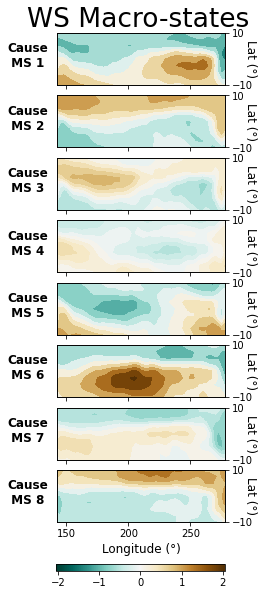

In [40]:
plot_macrostate_means(data=X, lbls=xlbls, cmap_label='WS (m/s)', c_or_e='Cause', 
    series_label='WS')

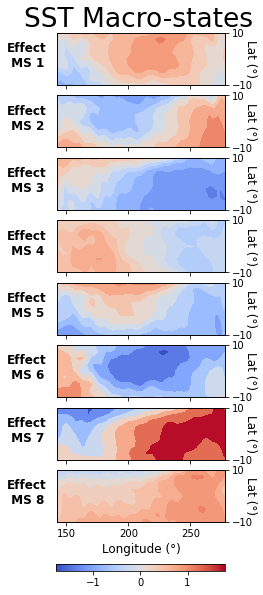

In [41]:
plot_macrostate_means(data=Y, lbls=ylbls, cmap_label='SST (°C)', c_or_e='Effect', 
    series_label='SST')

Now we can look at the conditional relationship between cause and effect
at the macrovariable level:

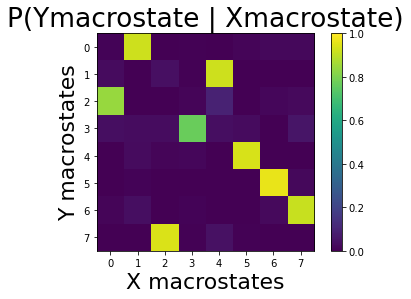

[[8.23305890e-03 9.24635845e-01 6.33312223e-04 7.59974668e-03
  0.00000000e+00 1.51994934e-02 2.34325522e-02 2.02659911e-02]
 [3.00375469e-02 0.00000000e+00 4.08844389e-02 5.00625782e-03
  9.24071756e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [8.45774213e-01 0.00000000e+00 0.00000000e+00 1.54225787e-02
  9.43861814e-02 0.00000000e+00 1.91239975e-02 2.52930290e-02]
 [3.74787053e-02 3.18001136e-02 3.40715503e-02 7.72856332e-01
  3.86144236e-02 2.83929585e-02 0.00000000e+00 5.67859171e-02]
 [0.00000000e+00 2.87128713e-02 1.28712871e-02 1.78217822e-02
  0.00000000e+00 9.40594059e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 8.50159405e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 9.68119022e-01 2.33793836e-02]
 [1.28571429e-02 3.61904762e-02 0.00000000e+00 9.04761905e-03
  0.00000000e+00 4.76190476e-04 2.52380952e-02 9.16190476e-01]
 [0.00000000e+00 0.00000000e+00 9.42807626e-01 5.77700751e-03
  4.56383593e-02 5.77700751e-03 0.00000000e+00 0.00000000e+00]]

In [46]:
from cfl.post_cfl.macro_cond_prob import compute_macro_cond_prob

P_Ym_given_Xm = compute_macro_cond_prob(data=None, exp='el_nino_results/experiment0001', 
                                        visualize=True)
print(P_Ym_given_Xm)

### Label New Data

With a trained CFL pipeline, we can also add new microvariable samples to the Experiment and construct a mapping to the macrovariable representation using `predict`.

For the sake of demonstration, we will just add the dataset we used to train the pipeline here as a new dataset.

In [47]:
# add a new dataset to this experiment's known set of data sets 
my_exp.add_dataset(X=X, Y=Y, dataset_name='dataset_test')

# run the new dataset through the trained cfl pipeline
pred_results = my_exp.predict('dataset_test')

print('X macrovariable states:')
pred_results['CauseClusterer']['x_lbls']

Beginning Experiment prediction.
Beginning CondDensityEstimator prediction...
CondDensityEstimator prediction complete.
Beginning CauseClusterer prediction...
CauseClusterer prediction complete.
Beginning EffectClusterer prediction...


100%|██████████| 13140/13140 [00:20<00:00, 638.12it/s]


EffectClusterer prediction complete.
Prediction complete.
X macrovariable states:


array([3, 4, 5, ..., 7, 3, 0], dtype=int32)

### Microvariable Importance
To understand to what extent each microvariable informs the macrovariable state
boundaries, we can use the `compute_microvariable_importance` post-CFL method.
This method takes each pair of macrovariable states takes their respective 
distributions of each microvariable, and computes the KL divergence between
the two. A higher KL divergence indicates a microvariable that is more 
informative in discriminating between these two states. 
Below, the average KL divergence is computed across all state pairs and plotted
for WS and SST.

100%|██████████| 8/8 [00:17<00:00,  2.24s/it]


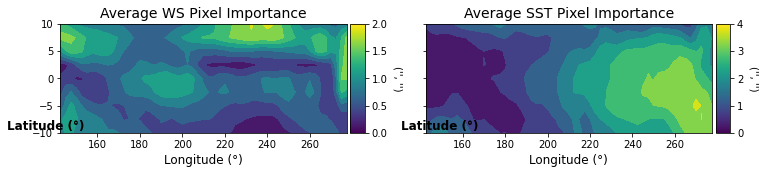

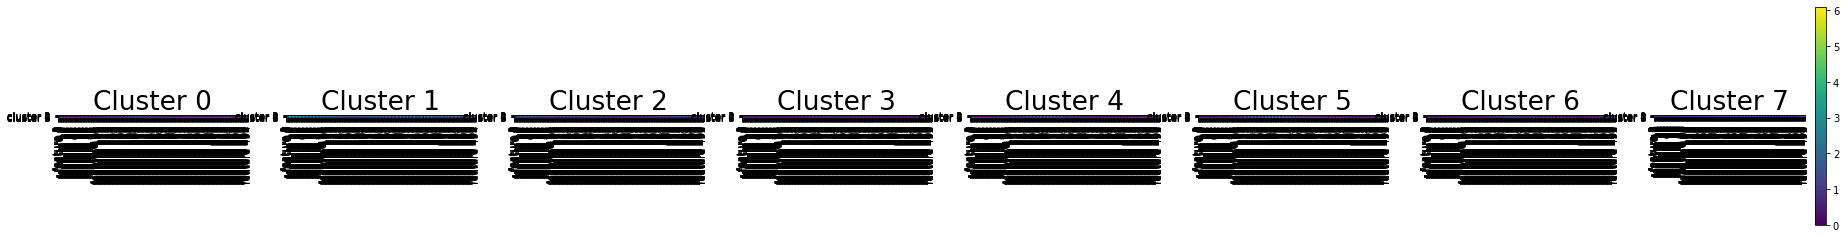

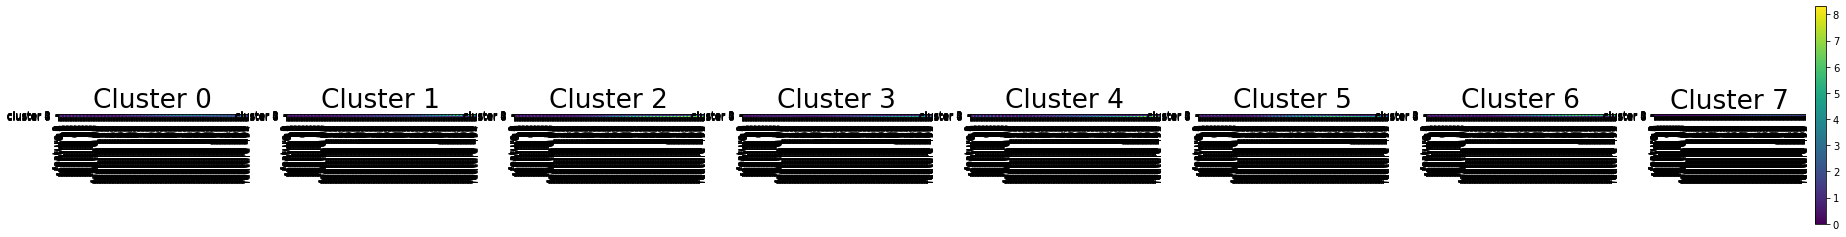

In [51]:
from cfl.post_cfl.microvariable_importance import compute_microvariable_importance

fig,ax = plt.subplots(1,2, figsize=(12,2), sharex=True, sharey=True)
spaces = ['cause', 'effect']
samples = [X, Y]
titles = ['Average WS Pixel Importance', 'Average SST Pixel Importance']

# compute importances for WS and SST spaces
for i in range(2):
    importances = compute_microvariable_importance(
                            exp='el_nino_results/experiment0001', 
                            data=samples[i], 
                            cause_or_effect=spaces[i])
    # set subplot labels based on position in figure
    if i==0:
        cmap_label = '' if i==0 else 'KL Divergence Importance Metric', ''

    # plot importance maps
    plot_contour_map(data=np.mean(importances,(0,1)), ax=ax[i], imshape=IMSHAPE, 
                    title=titles[i], cmap='viridis', 
                    cmap_label=cmap_label)
plt.savefig('el_nino_results/experiment0001/dataset_train/importance_maps', 
            bbox_inches='tight')
            

## Intervention Recommendation
Once CFL identifies macrovariable states that are unique in their conditional
relations, interventional data is still needed to determine whether these
state distinctions are based on causal relations as well (CFL's principled
aggregation method constructs state boundaries that *include* all causal
state boundaries, but may also include additional boundaries due to confounding
that must be ruled out). The `get_recommendations` method will suggest
microvariable cause values that CFL was particularly certain about in it's
class assignments, so that a researcher can intervene to the highest-yield
values in experimentation.  

array([0., 0., 0., ..., 0., 0., 0.])

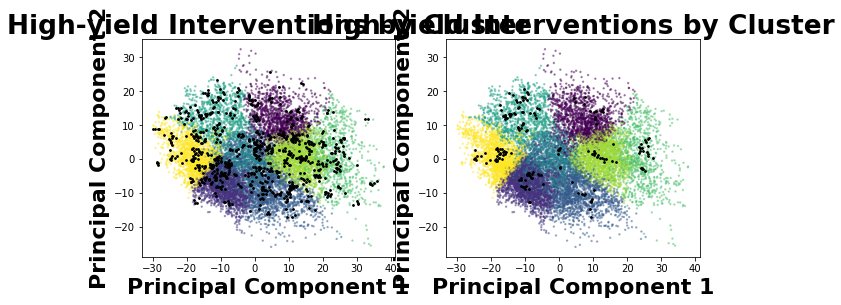

In [52]:
from cfl.post_cfl.intervention_rec import get_recommendations

get_recommendations(exp='el_nino_results/experiment0001', data=None, 
                         dataset_name='dataset_train', 
                         cause_or_effect='cause', visualize=True, k_samples=100,
                         eps=0.5)


### References 

This notebook is based on a notebook created by Krzysztof Chalupka in 2016: http://people.vision.caltech.edu/~kchalupk/code.html